# A Tessellated Approach to Fine-Scale Tracking of Endangered Birds and Bats Surrounding the Block Island Wind Farm


## Introduction
With the construction of the Block Island Wind Farm (BIWF) in 2015, the meso-scale avoidance patterns of migratory birds and bats around the BIWF remains largely unstudied. Previous attempts, such as {cite:t} 'loring_griffin_janaswamy_paton_sievert_2016' and {cite:t} 'janaswamy2018state' only achieved macro-scale movement patterns of endangered wildlife due to their over-reliance on estimated biological models. Although this method is highly resource-efficient, requiring a low station density in the area of interest, it fails to provide reasonable meso-scale behavior given the wide range of locations an animal can be given a certain detection value. 

### Transition to a New Technique 
To provide meso-scale movement behavior, a new technique needed to be developed. Given the BIWF's proximity to shore a basic triangulation scheme was devised to study the meso- and fine-scale movement patterns of endangered birds and bats in and around the BWIF. Although station intensive, requiring three simultaneous detections to provide a high-confidence detection, this method should provide the resolution required to track the meso-scale patterns of the birds and bats throughout the wind farm.    

Cooperation with the wind farm developer has allowed for the deployment of three stations located at Black Rock Beach, South East Light House, and a station located on a turbine service platform within the wind farm. Each station will contain four circularly polarized yagi-uda directional antennas on a 20m mast offset at 90 degrees from each other and one onmi-directional antenna.  These stations are expected to be fully operational in May 2021.  

For a basic triangulation model to be successful the following must be achieved to provide reasonable results: 

First, a known radiation pattern must be derived for each antenna. The radiation pattern describes the angular and radial dependence of received signal strength to the putative location of the transmitter and is dependent on the antenna's gain, the number of reflectors, and its polarization. The radiation pattern can be thought of as the area in which an antenna can "see" a transmitter. Once this radiation pattern is known,  we can develop tesselated shells of equal signal strength to perform basic triangle-to-triangle intersections. Given a sufficient number of intersections, minimally, 3, a putative location of the tag can be derived.    

Secondly, the interactions between antennas must also be quantified. Although radiation patterns can readably be generated using lab equipment, interactions with the metal tower and reflections from other antennas must be numerically approximated. These interactions can wildly affect the radiation pattern and thus are critical to understanding to allow for proper triangulations. 

### Calibration Campaign 
To determine our radiation patterns, a calibration campaign was undertaken from March 21st to April 10th, 2021. 
To properly determine the radiation pattern, a known transmitter was strapped to a DJI Mavic Air 2 Drone and flown throughout the putative radiation pattern of the antenna. The tag, transmitting every 10 seconds, would be received by one or more antennas on the station which would record the time of detection, the relative strength of the detection (in dBm), and which antenna received the transmission. 

To gather location-based information on each transmission a Garmin 130 cycling computer was attached also attached to the drone. The cycling computer, equipped with an onboard barometer, transmitted every 1 second, and provided latitude, longitude, and elevation data at each timestep during the flight of the drone. 

Upon the completion of every flight, the GPS data was exported from its Garmin native format (FIT) and converted to a GPX data file. Each GPX file was concatenated together and then converted into a plain-text CSV file for this analysis. The stations' data was precleaned to include only test tag detections and then exported in its native CSV format. 

It is the goal of this paper to explore the radiation pattern and to identify the best resolution that can be achieved using our calibration method. We also hope to begin to quantify the interaction of each yagi antenna on the station as a whole. 



## Analysis 

To begin our analysis, we must first ensure that all of the required python packages are installed. For this analysis, we are using Python 3 running on a Linux-based operating system. We do this by writing a simple install function and call the required python packages.

In [1]:
#Basic Packages
import subprocess
import sys
#Implenting a function to insall more complex packages
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
#installing the required 3rd party packages
install('pandas')
install('datetime')
install('numpy')
install('navpy')
install('plotly')
#import the require packages to run our software
import pandas as pd
import plotly.express as px
import datetime as dt
import time
import numpy as np
import multiprocessing as mp
import final_proj_functions as fpf
import navpy 
import matplotlib.pyplot as plt
import math as m
import plotly.graph_objects as go


Once we have run this code block, we can now freely work with the required packages to complete our analysis. If at any time during our analysis we find that a new package is required, we will append it to the code block above. 

The next step in analyzing our data is to import our data from their respective CSVs and begin the initial cleaning of our data. For simplicity, we will start with our GPS data as it contains the least complex cleaning algorithm. To clean our GPS data, we simply import the CSV using pandas and select only the columns as they relate to latitude, longitude, elevation, and time. We also take the time here and ensure that our time column is the correct data type, that is a pandas DateTime, for easy comparisons with the tag data when it is cleaned.

In [2]:
#import our gps data as pandas dataframe
gps_data_csv = 'apr7_data.csv'
gps_data_raw = pd.read_csv(gps_data_csv)
gps_data_sorted = gps_data_raw[['Y', 'X', 'ele','time']].copy()
gps_data_sorted['time']= pd.to_datetime(gps_data_sorted['time']) 
gps_data_sorted['time']= pd.to_datetime(gps_data_sorted['time']) 

It is important to note that for any new calibration files, only the CSV needs to be changed. 

Once the GPS data is imported and cleaned, we can move on to the antenna data. Due to the complex nature of the antenna data cleaning process, we have written a series of helper functions to streamline the code in this Jupyter notebook. However, the explanations are as follows: 

First, we will utilize the antenna_puller function to separate data from each antenna. This function takes in the raw test tag CSV and the antenna number and filters out data that is not the antenna of interest. We complete this 5 times, one for each antenna in our array. 

In [3]:
#defining our antenna data
antenna_data_csv = 'apr7_tag.csv'

#utilizing our antenna_puller function we are going to import our antenna data for each different antenna 
#yagi antenna 1
antenna_1_data = fpf.antenna_puller(antenna_data_csv,1) 
#yagi antenna 2
antenna_2_data = fpf.antenna_puller(antenna_data_csv,2) 
#yagi antenna 3
antenna_3_data = fpf.antenna_puller(antenna_data_csv,3) 
#yagi antenna 4
antenna_4_data = fpf.antenna_puller(antenna_data_csv,4) 
#omnidirectional antenna
antenna_5_data = fpf.antenna_puller(antenna_data_csv,5) 

Again the function is structured in such a way that for any new calibration data that may be obtained, only a simple replacement of the CSV file is required. 

Once the antenna data is discriminated, we can now begin the comparison of the tag data to the GPS data. To do this we have developed several helper functions that are nested in the latlong_of_detections_creator function. The broad strokes of this function is to compare the GPS data and the Antenna data to see if there was a detection on the antenna that correlates to a GPS ping. Given that our GPS data is an order of magnitude larger than our antenna data, the number of comparisons is sufficiently large to warrant multi-threading this function. 

More specifically, the lat_long_of_detections function takes the imported antenna and GPS data frames and generates a data frame containing the latitude, longitude, elevation, and RSSI of a detected point. This is done by splitting the GPS data into chunks, the number of which is equal to the number of cores available on the user's computer. These chunks are first passed to the split_ident function which calls the comparion_loop function. Variables are passed globally between the functions. 

The comparison_loop function converts each timestamp to epoch time and measures to see if there is a difference between the two timesteps. If there is no difference, then the GPS data and RSSI are appended to a holding matrix. Each matrix, developed individually by each core, is then appended together to form a combined matrix describing the RSSI at latitude, longitude, and elevation. 

In [4]:
#combining the gps and tag data by antenna to show the detected dbm at various points
lat_long_of_detections_1 = fpf.latlong_of_detections_creator(gps_data_sorted, antenna_1_data)
lat_long_of_detections_2 = fpf.latlong_of_detections_creator(gps_data_sorted, antenna_2_data)
lat_long_of_detections_3 = fpf.latlong_of_detections_creator(gps_data_sorted, antenna_3_data)
lat_long_of_detections_4 = fpf.latlong_of_detections_creator(gps_data_sorted, antenna_4_data)
lat_long_of_detections_5 = fpf.latlong_of_detections_creator(gps_data_sorted, antenna_5_data)

Once, this function has been sucessfully run, we now know the tag's signal strength at various GPS locations. To be able to understand the radiation pattern of each yagi antenna in a general sense, we must convert the latitude,longitude, and elevation to the local coordinates of the antenna. 

This was completed by manually defining the location and elevation of the test station. We then use a helper function from the navpy function to conver this location from latitude and longitude coordinates to earth-centered x,y,z coordinates. This provides us our 0-point to compare all of the other points to. 

We then utilize our xyz_converted function, intaking the station location, the station offset, and the results from the latlong_of_dectections_creator for each antenna and iterates over each point converting them to localized x,y,z coordinates. 

In [5]:
#manually define the station location 
station_location = [41.520752667,-71.599254667,40.0];
station_offset = navpy.lla2ecef(station_location[0],station_location[1],station_location[2])

ant1_xyz = fpf.xyz_converter(station_location,station_offset,lat_long_of_detections_1)
ant2_xyz = fpf.xyz_converter(station_location,station_offset,lat_long_of_detections_2)
ant3_xyz = fpf.xyz_converter(station_location,station_offset,lat_long_of_detections_3)
ant4_xyz = fpf.xyz_converter(station_location,station_offset,lat_long_of_detections_4)
ant5_xyz = fpf.xyz_converter(station_location,station_offset,lat_long_of_detections_5)    



Now that our data has been clean we can begin our analysis in earnest. 

Due to the simplicity of the omnidirectional antenna because of its spherical symmetry,  we will start by looking at the properties of antenna 5. The first property we will be looking at is the putative range that the omni-antenna gives us. We do this first by converting our cartesian positions to spherical coordinates using of cart2sph helper function, saving the radius and plotting this against rssi.  

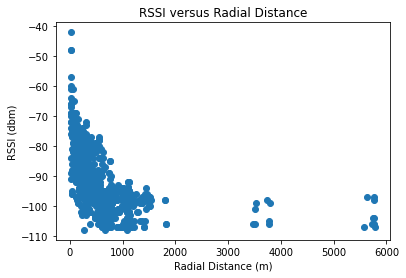

In [6]:
#We generate an empty matrix for X
x_5 = []
for x in range(0,len(ant5_xyz)):
    x_5.append(ant5_xyz[x][0])
#An empty matrix for Y
y_5 = []
for y in range(0,len(ant5_xyz)):
    y_5.append(ant5_xyz[y][1])
#An empty matrix for Z
z_5 = []
for z in range(0,len(ant5_xyz)):
    z_5.append(ant5_xyz[z][2])
#And an empty matrix for the RSSI
rssi_5 = []
for dbm in range(0,len(ant5_xyz)):
    rssi_5.append(ant5_xyz[dbm][3])

#We will now iterate over each set of points, covert them to
#speherical coordinates and appened them to our master list. 
spherical_coordinates_radius = []
for xyz in range(0,len(ant5_xyz)):
    [radius, ele, az] = fpf.cart2sph(x_5[xyz],y_5[xyz],z_5[xyz])
    spherical_coordinates_radius.append(radius)    

#Plot our Solution 
plt.plot(spherical_coordinates_radius,rssi_5,'o')
plt.xlabel("Radial Distance (m)")
plt.ylabel("RSSI (dbm)")
plt.title("RSSI versus Radial Distance")
plt.show()


Given this plot, we can see that a great number of detections are between zero meters and two-thousand meters but we have, what seems, to be supurious detections at 3.5km and 5.9km. To quantify this, we will look at variety of parameters of our radial data. 

In [7]:
numb_less_2000 = 0
for i in spherical_coordinates_radius :
    if i < 2000 :
        numb_less_2000 = numb_less_2000 + 1
print('The number of points less than 2000m is: '+ str(numb_less_2000))

The number of points less than 2000m is: 761


In [8]:
numb_great_2000 = 0
for i in spherical_coordinates_radius :
    if i > 2000 :
        numb_great_2000 = numb_great_2000 + 1
print('The number of points greater than 2000m is: '+ str(numb_great_2000))
print('\n')
print('The number of points greater than 2000m represents ' + str(round(numb_great_2000/(numb_great_2000 + numb_less_2000) * 100,2)) +' percent of the data' )

The number of points greater than 2000m is: 17


The number of points greater than 2000m represents 2.19 percent of the data


Given this, and given the fact that the data is no longer continuous after 2000m, the usable range of the omni-antenna is 2000 meters. 

The next thing we want to look at with the omni-drectional antenna is it's putative radiation pattern. Generally speaking omni-drectional antenna radiation patterns look like spheres. However, to test this we will generate a polar plot looking at the radial relationship to azimuth through the field. With omni-drectional antennas, we could do this at any RSSI and expect similar results. However, in discussions with the station and antenna developers they suggested using -100 dBm as the noise floor, thus we will plot the radiation pattern at that RSSI value. We will also filter detections greater than 2000m to better visualize our radiation pattern. 

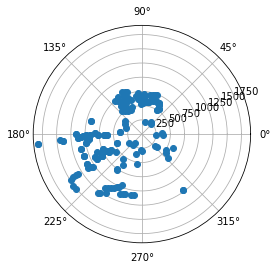

In [9]:
spherical_coordinates_az = []
spherical_coordinates_radius = []
for xyz in range(0,len(ant5_xyz)):
    [radius, ele, az] = fpf.cart2sph(x_5[xyz],y_5[xyz],z_5[xyz])   
    if radius <= 2000 and rssi_5[xyz] <= -100:
        spherical_coordinates_radius.append(radius)  
        spherical_coordinates_az.append(az)

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(spherical_coordinates_az,spherical_coordinates_radius,'o')
plt.show()


As we can see, our radiation pattern is far from symmetric with points rapidly dropping below the manufacutred reccomended noise floor before reaching the putative two kilometer range. As we can see from the topographical map below, this is easily explain as we can see that our station (marked by a black dot) is located in a valley with hills blocking detected signals to the north and west and a a densely forrested swamp detecting singals to the east. Thus it is reasonable that our best results are going to be south of the station. To better understand the omni-directional's radiation pattern we will require more data in a more topograhically conducive area. ![alt text](topographical_mapping_Dougs_House.jpg "Topographical Map of Station Location") 





Now that we have completed our preliminary analysis on the omni-directional antenna, it is time to review the yagi antennas. Although we could review each antenna individually, we know that each antenna should act identically. Thus to optimize our analysis, we are going to use the antennas relative positions (each antenna is offset to its neighbor by 90 degrees) and rotate the antennas data onto a reference antenna. This will allow us to use detections from one-antenna to artifically increase the overall N-number for our putative radiation pattern. 

We will do this manually, first by generating the x,y,z coordinates for each antenna and by pulling out the rssi for each detection. We will then convert everything to spherical coordinates before roating the azimuth angle the appropriate amount. We will then concatenate our data to have our composite detection matirx. We do that with the code below.  

In [10]:
#We will first split our X detections. We do this seperately across each antenna
x_1=[]
for x in range(0,len(ant1_xyz)):
    x_1.append(ant1_xyz[x][0])
    
x_2 = []
for x in range(0,len(ant2_xyz)):
    x_2.append(ant2_xyz[x][0])    

x_3 = []
for x in range(0,len(ant3_xyz)):
    x_3.append(ant3_xyz[x][0])    
    
x_4 = []
for x in range(0,len(ant4_xyz)):
    x_4.append(ant4_xyz[x][0])    
        
#And then our Y detections similarly to our x-detections
y_1 = []
for y in range(0,len(ant1_xyz)):
    y_1.append(ant1_xyz[y][1])
    
y_2 = []
for y in range(0,len(ant2_xyz)):
    y_2.append(ant2_xyz[y][1])    

y_3 = []
for y in range(0,len(ant3_xyz)):
    y_3.append(ant3_xyz[y][1])    
    
y_4 = []
for y in range(0,len(ant4_xyz)):
    y_4.append(ant4_xyz[y][1])      
    
#And then our Z detections 
z_1 = []
for z in range(0,len(ant1_xyz)):
    z_1.append(ant1_xyz[z][2])
    
z_2 = []
for z in range(0,len(ant2_xyz)):
    z_2.append(ant2_xyz[z][2])    

z_3 = []
for z in range(0,len(ant3_xyz)):
    z_3.append(ant3_xyz[z][2])    
    
z_4 = []
for z in range(0,len(ant4_xyz)):
    z_4.append(ant4_xyz[z][2])  

#Finally we can split out our detection RSSI
rssi_1 = []
for dbm in range(0,len(ant1_xyz)):
    rssi_1.append(ant1_xyz[dbm][3])
    
rssi_2 = []
for dbm in range(0,len(ant2_xyz)):
    rssi_2.append(ant2_xyz[dbm][3])    
    
rssi_3 = []
for dbm in range(0,len(ant3_xyz)):
    rssi_3.append(ant3_xyz[dbm][3])
    
rssi_4 = []
for dbm in range(0,len(ant4_xyz)):
    rssi_4.append(ant4_xyz[dbm][3])

    
#We know need to convert everything to spherical coordinates. We generate a master-list of radial and azimuth values
#We also generate the master list for the rssi here which is simply the concatenation of the other rssi lists 
spherical_coordinates_az = []
spherical_coordinates_radius = []
spherical_coordinates_elevation = []

master_rssi = rssi_1 + rssi_2 + rssi_3 + rssi_4
for xyz in range(0,len(ant1_xyz)):
    [radius, ele, az] = fpf.cart2sph(x_1[xyz],y_1[xyz],z_1[xyz])
    spherical_coordinates_radius.append(radius)  
    spherical_coordinates_az.append(az)
    spherical_coordinates_elevation.append(ele)
    
#For each antenna we know that we have a 90 degree offset from the previous one. Python handles these values 
#as radians so we add the appropirate value before appending it to the master matrix
for xyz in range(0,len(ant2_xyz)):
    [radius, ele, az] = fpf.cart2sph(x_2[xyz],y_2[xyz],z_2[xyz])   
    spherical_coordinates_radius.append(radius)  
    spherical_coordinates_az.append(az+ 1.5708)
    spherical_coordinates_elevation.append(ele)
    

#adding 180 degree in radians to align this antenna with the reference antenna. :    
for xyz in range(0,len(ant3_xyz)):
    [radius, ele, az] = fpf.cart2sph(x_3[xyz],y_3[xyz],z_3[xyz])   
    spherical_coordinates_radius.append(radius)  
    spherical_coordinates_az.append(az+ 3.14159)
    spherical_coordinates_elevation.append(ele)
    

#adding 270 degrees in radians to align this antenna with the reference antenna.     
for xyz in range(0,len(ant4_xyz)):
    [radius, ele, az] = fpf.cart2sph(x_4[xyz],y_4[xyz],z_4[xyz])   
    spherical_coordinates_radius.append(radius)  
    spherical_coordinates_az.append(az+ 4.71239)
    spherical_coordinates_elevation.append(ele)
        

Once this has been completed, we can very easily plot the rssi of the detected signal to the radius. 

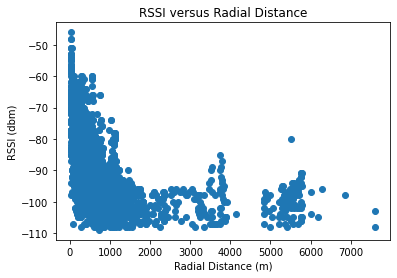

In [11]:
# We can know plot the RSSI vs. Radial Distance Plot. 
plt.plot(spherical_coordinates_radius,master_rssi,'o')
plt.xlabel("Radial Distance (m)")
plt.ylabel("RSSI (dbm)")
plt.title("RSSI versus Radial Distance")
plt.show()

From this graph, we can see that we have consistent data out to 4km with sparer data at greater than 5km. To test othe range on our yagi antenna, we preform a similar test to what we did with the omnidirectional antenna. 

In [12]:
numb_great_6000 = 0
for i in spherical_coordinates_radius :
    if i > 6000 :
        numb_great_6000 = numb_great_6000 + 1
print('The number of points greater than 6000m is: '+ str(numb_great_6000))
print('\n')
print('The number of points greater than 6000m represents ' + str(round(numb_great_6000/(len(spherical_coordinates_radius)) * 100,2)) +' percent of the data' )

The number of points greater than 6000m is: 7


The number of points greater than 6000m represents 0.2 percent of the data


From this, we can reasonanly set our usable detection range at 6km without cutting out a vast amount of data. 

Next, we want to look at the polar plot of the composite radiation pattern. 

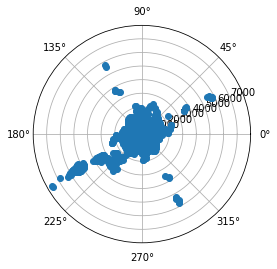

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(spherical_coordinates_az,spherical_coordinates_radius,'o')
plt.show()


As is expected with a yagi radiation pattern, we have a spherical radiation pattern close to the center of the station with a longer lobe jutting off at roughly 220 degrees. What is unusal are the spurious detections off axis from each antenna. It is entirely possible that these are reflections off of the tower. Further investigations is needed to quanitfy the source of these points.

Now that we have explore the properties of the antennas at the calibration site, we want to translate this calibration data over to sites the stations will be deployed at during Summer 2021. This will be done by taking our generated composite radiation pattern and generating a 4 yagi antenna station from it. We do this for each antenna by converting the spherical coordinates we have generated above and converting them to cartesian coordinates. We do this using a sph2cart function defined below. We also apply a rotational factor to the azimuth angle if required. 

Next, we generate a master list of x,y,z points of each combined antenna generating the station object. This object is then imprinted onto each of our putative station locations. This is done using the lat_long_converter function which takes in the station location and generates a set of latitude and longitude points from the station. 

Finally, we plot this data on a map to visualize the potential dection regions of our deployed stations. This is all completed by the code below: 

In [14]:
def sph2cart(az, el, r):
    rcos_theta = r * np.cos(el)
    x = rcos_theta * np.cos(az)
    y = rcos_theta * np.sin(az)
    z = r * np.sin(el)
    return [x, y, z]


def lat_long_converter(xyz_positions,new_station_location):
    station_offset = navpy.lla2ecef(new_station_location[0],new_station_location[1],new_station_location[2])
    lat_long_location = []
    for i in range(len(xyz_positions)):
        lat_long_location.append(navpy.ecef2lla(xyz_positions[i][0:3] + station_offset))
    return lat_long_location
    

combined_antenna_1_xyz = []
for rtp in range(0,len(spherical_coordinates_radius)):
    r = spherical_coordinates_radius[rtp]
    t = spherical_coordinates_az[rtp]
    p = spherical_coordinates_elevation[rtp] 
    position = sph2cart(t,p,r)
    combined_antenna_1_xyz.append(position)

combined_antenna_2_xyz = []
for rtp in range(0,len(spherical_coordinates_radius)):
    r = spherical_coordinates_radius[rtp]
    t = spherical_coordinates_az[rtp] + 1.5708
    p = spherical_coordinates_elevation[rtp] 
    position = sph2cart(t,p,r)
    combined_antenna_2_xyz.append(position)

combined_antenna_3_xyz = []
for rtp in range(0,len(spherical_coordinates_radius)):
    r = spherical_coordinates_radius[rtp]
    t = spherical_coordinates_az[rtp] + 3.14159
    p = spherical_coordinates_elevation[rtp] 
    position = sph2cart(t,p,r)
    combined_antenna_3_xyz.append(position)

combined_antenna_4_xyz = []
for rtp in range(0,len(spherical_coordinates_radius)):
    r = spherical_coordinates_radius[rtp]
    t = spherical_coordinates_az[rtp] + 4.71239
    p = spherical_coordinates_elevation[rtp] 
    position = sph2cart(t,p,r)
    combined_antenna_4_xyz.append(position)

comined_station_xyz = combined_antenna_1_xyz + combined_antenna_2_xyz   
comined_station_xyz = comined_station_xyz + combined_antenna_3_xyz + combined_antenna_4_xyz  


SE_station_location = [41.15314520844613, -71.55187171683201,40.0]                                
BR_Station_location = [41.148,  -71.5901,40.0]
WT_Station_location = [41.1257,-71.5076,40.0]

SE_Light_Station = lat_long_converter(comined_station_xyz,SE_station_location) 
BR_Station = lat_long_converter(comined_station_xyz,BR_Station_location) 
WT_Station = lat_long_converter(comined_station_xyz,WT_Station_location)

combined_Station = SE_Light_Station + BR_Station + WT_Station

lat_long_dataframe = pd.DataFrame(combined_Station,columns = ['lat','long','elevation'])

fig = px.scatter_mapbox(lat_long_dataframe, lat="lat", lon="long", height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()



As we can see from our map, our stations provide reasonable coverage of the lease-area, however given the directional nature of the yagi antennas, the primary beams must be pointed in such a away to optimize coverage of the wind-farm. 

## Conclusion 
The intial goal of our calibration studies were to idenitfy the restrictions of the new 434MHz antennas and begin to derive the putative radiation pattern of the antennas. From our analysis, we can see that location of our station was sub-optimal with a variety of enviromental factors interfering with the proper calibration of the antennas. However, we were able to gain useful insights on the range with the omnidirectional antenna having a putative 2km range and the yagi antenna's primary lobe having an 6km range. We were also able to identify areas of further investigation, such as the off-axis detections on the yagi-antennas. Finally, we were able to begin to visualize the potential detection zones of our antenna array as it overlooks the Block Island Wind Farm. 